In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import warnings

# Ignore a bunch of Arviz/pymc3 deprecated warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_FOLDER = '../../data'
RUGGED_DATA = 'rugged.csv'

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{RUGGED_DATA}')
df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [4]:
df.columns

Index(['isocode', 'isonum', 'country', 'rugged', 'rugged_popw', 'rugged_slope',
       'rugged_lsd', 'rugged_pc', 'land_area', 'lat', 'lon', 'soil', 'desert',
       'tropical', 'dist_coast', 'near_coast', 'gemstones', 'rgdppc_2000',
       'rgdppc_1950_m', 'rgdppc_1975_m', 'rgdppc_2000_m', 'rgdppc_1950_2000_m',
       'q_rule_law', 'cont_africa', 'cont_asia', 'cont_europe', 'cont_oceania',
       'cont_north_america', 'cont_south_america', 'legor_gbr', 'legor_fra',
       'legor_soc', 'legor_deu', 'legor_sca', 'colony_esp', 'colony_gbr',
       'colony_fra', 'colony_prt', 'colony_oeu', 'africa_region_n',
       'africa_region_s', 'africa_region_w', 'africa_region_e',
       'africa_region_c', 'slave_exports', 'dist_slavemkt_atlantic',
       'dist_slavemkt_indian', 'dist_slavemkt_saharan', 'dist_slavemkt_redsea',
       'pop_1400', 'european_descent'],
      dtype='object')

In [5]:
# rgdppc = real GDP per capita

df[['rgdppc_2000', 'rugged']].describe()

,rgdppc_2000,rugged
count,170.000000,234.000000
mean,9094.892853,1.375402
std,9699.991472,1.370052
min,466.647000,0.000000
25%,1880.829250,0.376000
50%,5314.742000,0.961500
75%,13100.150000,1.981000
max,57792.090000,7.811000


### Code 8.1

In [6]:
# extract countries with GDP data
df_gdp = df[df['rgdppc_2000'].notna()].copy()

# log transform variables 
df_gdp['log_gdp'] = np.log(df_gdp['rgdppc_2000'].values)

# rescale vars
df_gdp['log_gdp_std'] = df_gdp['log_gdp'] / np.mean(df_gdp['log_gdp'])
df_gdp['rugged_std'] = (df_gdp['rugged'] - np.min(df_gdp['rugged'])) / np.max(df_gdp['rugged'])

In [7]:
df_gdp[['country', 'log_gdp_std', 'rugged_std']].head()

,country,log_gdp_std,rugged_std
2,Angola,0.879712,0.137859
4,Albania,0.964755,0.552080
7,United Arab Emirates,1.166270,0.123509
8,Argentina,1.104485,0.124476
9,Armenia,0.914904,0.432925


In [8]:
# mean standardized ruggedness

np.mean(df_gdp['rugged_std'])

0.2144763548760362

## First Model

$$
\begin{align*}
~ \log ( y_i ) & \sim N( \mu_i, \sigma ) \\
         \mu_i & = \alpha + \beta \cdot ( r_i - \bar{r} ) \\
        \alpha & \sim N( 1, 1 )  \\
        \beta  & \sim N( 0, 1 ) \\
        \sigma & \sim \text{Exponential}(1)
\end{align*}
$$
where $\log (y_i)$ is the standardized log GDP and $r_i$ is the standardized ruggedness. If $r_i = \bar{r}$, we have that $\alpha = \mu_i$ and since the mean of the standardized log GDP is $1$, as a first guess, it makes sense to prescribe $\alpha \sim N( 1, 1 )$. We want to allow both positive and negative slopes without preference for any. As a first guess, we prescribe $\beta \sim N( 0, 1 )$.

### Code 8.2

In [9]:
mean_rugged = np.mean(df_gdp['rugged_std'])

with pm.Model() as m_8_1:
    a = pm.Normal('a', mu=1, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b * (df_gdp['rugged_std'] - mean_rugged))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sigma=sigma, observed=df_gdp['log_gdp_std'])
    
    trace_8_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [10]:
with pm.Model() as m_8_1t:
    a = pm.Normal('a', mu=1, sigma=0.1)
    b = pm.Normal('b', mu=0, sigma=0.3)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b * (df_gdp['rugged_std'] - mean_rugged))
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sigma=sigma, observed=df_gdp['log_gdp_std'])
    
    trace_8_1t = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Code 8.3

In [11]:
N_OBS = 50

with m_8_1:
    m_8_1_prior = pm.sample_prior_predictive(samples=N_OBS)
    
with m_8_1t:
    m_8_1t_prior = pm.sample_prior_predictive(samples=N_OBS)

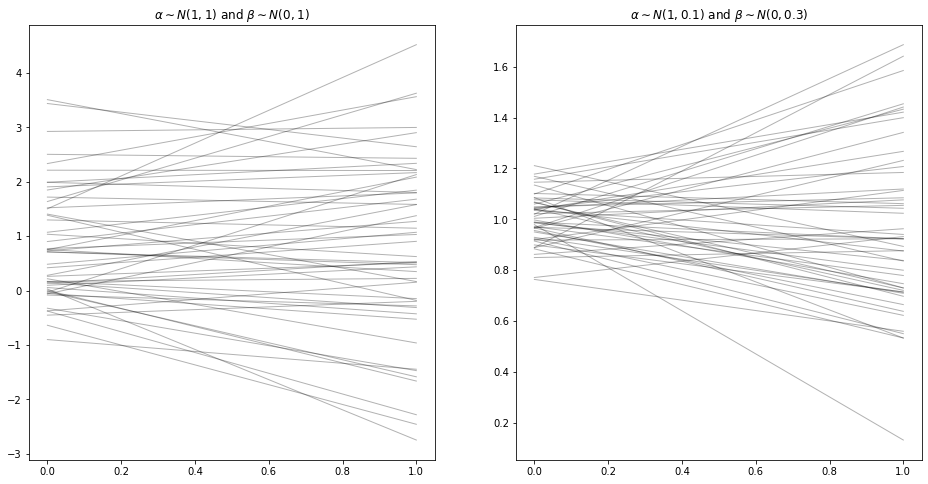

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


rugged_xvals = np.linspace(0.0, 1.0, num=N_OBS)

matrix_1 = m_8_1_prior['a'].reshape(1, -1) + rugged_xvals.reshape(-1, 1) * m_8_1_prior['b'].reshape(1, -1)
matrix_2 = m_8_1t_prior['a'].reshape(1, -1) + rugged_xvals.reshape(-1, 1) * m_8_1t_prior['b'].reshape(1, -1)

ax1.plot(rugged_xvals, matrix_1, color="k", lw=1, alpha=0.3)
ax1.set_title(r'$\alpha \sim N(1, 1)$ and $\beta \sim N(0, 1)$')

ax2.plot(rugged_xvals, matrix_2, color="k", lw=1, alpha=0.3)
ax2.set_title(r'$\alpha \sim N(1, 0.1)$ and $\beta \sim N(0, 0.3)$')
plt.show()